In [1]:
import numpy as np
import scipy as sp
import json, os

from qiskit.quantum_info import SparsePauliOp

from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import Statevector

import matplotlib.pyplot as plt

In [2]:
def get_hamiltonian(L, g, h):
    XX_tuples = [("XX", [i, i + 1], -g) for i in range(0, L - 1)] + [("XX", [L-1, 0], -g)]
    Z_tuples = [("Z", [i], -h) for i in range(0, L)]

    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *Z_tuples], num_qubits=L)
    return hamiltonian.simplify()

def exact_time_evolve(L,g,h,tf):
    in_st = ['0']*L
    i_st = ''.join(in_st)
    psi0 = Statevector.from_label(i_st)
    
    H = get_hamiltonian(L=L, g=g, h=h)
    H_array = H.to_matrix()
    # We define a slightly denser time mesh
    exact_times = np.linspace(0, tf, 151)
    # We compute the exact evolution using the exp
    exact_evolution = [psi0.evolve(sp.linalg.expm(-1j * time * H_array)) for time in exact_times]

    # Get all possible bi-partitions
    bipart = [[i for i in range(j)] for j in range(1,L)]

    data = []
    ind = 0
    for st in exact_evolution:
        erg = []
        eig_max = 0
        for party in bipart:
            l=L-len(party)
            H_Batt = SparsePauliOp.from_sparse_list([("Z", [i], 1.0) for i in range(0, l)], num_qubits=l)
            HBatt = H_Batt.to_matrix()
            En = np.linalg.eigh(HBatt)[0]+l
            
            rho = partial_trace(st,party)
            lmda = list(np.linalg.eigh(rho)[0])
            lmda.sort(reverse=True)
            lmda = np.array(lmda)
            if eig_max<max(lmda):
                eig_max = max(lmda)

            erg.append(np.sum(np.multiply(En,lmda)))
        erg_gap = []   
        for i in range(len(bipart)):
            erg_gap.append(erg[i]+erg[-1-i])
    
        prod = np.prod(erg_gap)
        erg_vol = pow(prod,1/len(erg_gap))
        data.append([erg_vol,1-eig_max])
    
    return exact_times, data

In [6]:
N_val = 10
t_val = np.linspace(0.1,1.35,6)
nrep_val = np.arange(6,14,2)
p_val = [i for i in range(1,N_val)]
Evol = np.zeros((len(t_val),len(nrep_val)))

for N in [N_val]:
    for i,t in enumerate(t_val):
        for j,nrep in enumerate(nrep_val):
            E_ps = []
            for p in p_val:
                file = f"QC_out_prerun/N={N:02d}/t={t:.3g}/nrep={nrep}/p={p}/summary.json"
                if os.path.exists(file) == False:
                    print(f"File {file} does not exist!")
                    continue
                
                with open(file, 'r') as f:
                    summary_data = json.load(f)
                E_ps.append(summary_data["E_passive"])
            
            if len(E_ps)==len(p_val):
                erg_gap = []
                for k in range(len(p_val)):
                    erg_gap.append(N+(E_ps[k]+E_ps[-1-k]))

                prod = np.prod(erg_gap)
                erg_vol = pow((prod),1/len(erg_gap))
                #print(i,j,erg_vol)

                Evol[i,j] = erg_vol


In [4]:

times, exact_data = exact_time_evolve(L=10,g=2.0,h=1.0,tf=1.5)

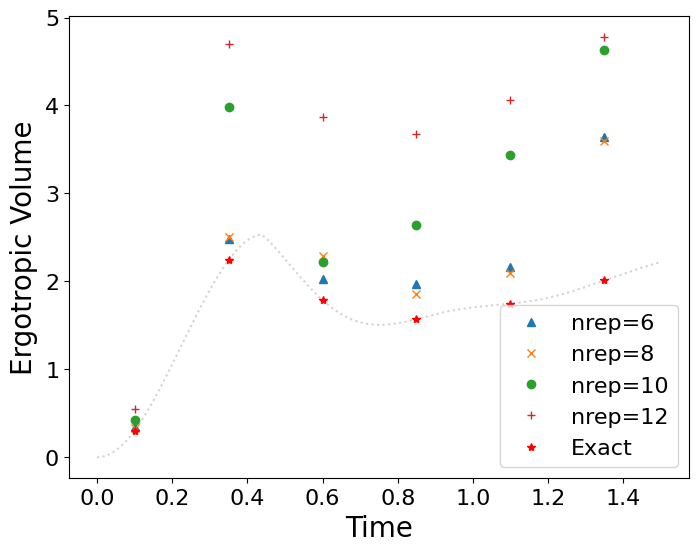

In [8]:
fnt_siz = 20
plt.figure(figsize=(8, 6))
markers = ['^','x','o','+','v']
idx = np.isin(np.round(times,2), t_val)

for i in range(0,len(nrep_val),1):
    plt.plot(t_val,Evol[:,i],markers[i],label=f"nrep={nrep_val[i]}")
plt.plot(times,np.array(exact_data)[:,0],':',color='gray',alpha=0.35)
plt.plot(times[idx],np.array(exact_data)[idx,0],'r*',label="Exact")
plt.legend(fontsize=16)
plt.xlabel(r'Time',fontsize=fnt_siz,labelpad=5)
plt.ylabel(r'Ergotropic Volume',fontsize=fnt_siz,labelpad=5)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
